In [106]:
from pathlib import Path
from itertools import product
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix, classification_report
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
path_FL = Path('../results/finland')
path_NL = Path('../results/netherlands')
path_results = Path('../results/comparison')

### Comparing model performance increase with extra predictors

In [4]:
def load_probas(path):
    dfs = []
    for sex, nback, foldersuffix in product(['men', 'women'], range(1,6), ['', '_hbonly']):
        df = pd.read_pickle(path / f'probas{foldersuffix}' / f'proba_{sex}_{nback}.pkl')
        df['sex'] = sex
        df['nback'] = nback
        df['variables'] = 'all' if foldersuffix == '' else 'hbonly' 
        dfs.append(df)
    return pd.concat(dfs)

In [86]:
probas_NL = load_probas(path_NL)
probas_FL = load_probas(path_FL)
probas = pd.concat([df.assign(country=k) for k,df in {'Finland':probas_FL, 'Netherlands':probas_NL}.items()])
probas = probas.reset_index()
probas = probas.drop_duplicates(subset=['index', 'country', 'variables', 'sex'], keep='last')

In [87]:
dfs = []
auprs = []
for name, group in probas.groupby(['sex', 'country', 'variables']):
    for i, outcome in enumerate(['low', 'ok']):
        prec, rec, thres = precision_recall_curve(group['HbOK'], group[f'prob_{outcome}'], pos_label=i)
        df = pd.DataFrame({'precision':prec[:-1],
                           'recall':rec[:-1],
                           'thresholds':thres})
        df['sex'] = name[0]
        df['country'] = name[1]
        # df['nback'] = name[2]
        df['variables'] = name[2]
        df['outcome'] = outcome
        dfs.append(df)
        
        # defrates[f'{name[0]}-{name[1]}-{name[2]}-{name[3]}-{outcome}'] = np.mean(group['HbOK'] == i)
        # auprs[f'{name[0]}-{name[1]}-{name[2]}-{name[3]}-{outcome}'] = round(average_precision_score(group['HbOK'], group[f'prob_{outcome}'], pos_label=i), 3)
        auprs.append([name[0], name[1], name[2], outcome, 
                      round(average_precision_score(group['HbOK'], group[f'prob_{outcome}'], pos_label=i), 3),
                      np.mean(group['HbOK'] == i)])
        
probasdf = pd.concat(dfs)

In [88]:
auprs = pd.DataFrame(auprs, columns=['sex', 'country', 'variables', 'outcome', 'aupr', 'base_prob'])
auprs['aupr_adjusted'] = auprs['aupr'] - auprs['base_prob']
auprs

,sex,country,variables,outcome,aupr,base_prob,aupr_adjusted
0,men,Finland,all,low,0.114,0.010286,0.103714
1,men,Finland,all,ok,0.999,0.989714,0.009286
2,men,Finland,hbonly,low,0.076,0.010286,0.065714
3,men,Finland,hbonly,ok,0.998,0.989714,0.008286
4,men,Netherlands,all,low,0.089,0.010963,0.078037
5,men,Netherlands,all,ok,0.998,0.989037,0.008963
6,men,Netherlands,hbonly,low,0.079,0.010963,0.068037
7,men,Netherlands,hbonly,ok,0.998,0.989037,0.008963
8,women,Finland,all,low,0.140,0.025353,0.114647
9,women,Finland,all,ok,0.995,0.974647,0.020353


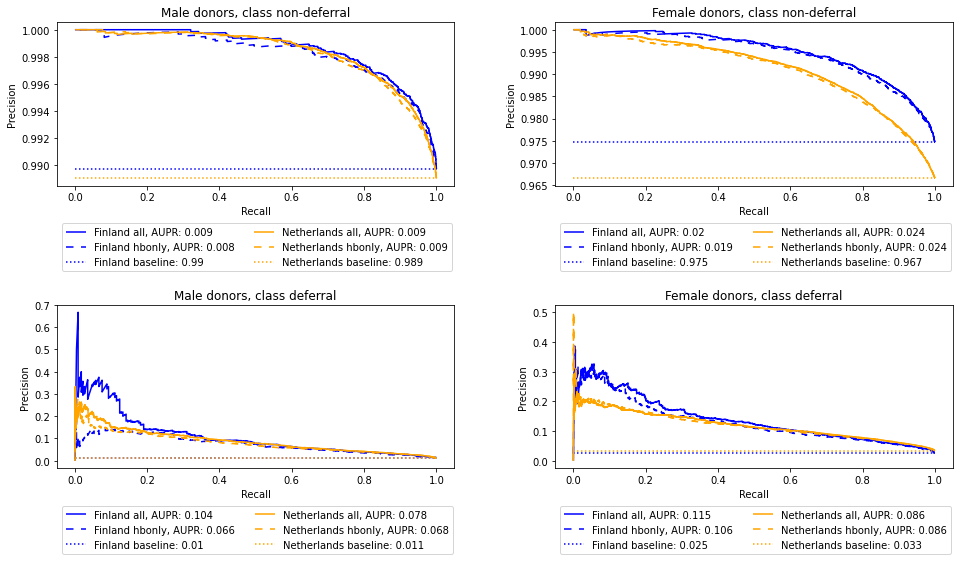

In [98]:
fig, ax = plt.subplots(2, 2, figsize=(14,8))

for (x, sex), (y, outcome) in product(enumerate(['men', 'women']), enumerate(['ok', 'low'])):
    dfsub = probasdf.loc[(probasdf['sex'] == sex) & 
                         (probasdf['outcome'] == outcome), ]
    
    for name, group in dfsub.groupby(['country', 'variables']):
        aupr = auprs.loc[(auprs.sex == sex) &
                         (auprs.country == name[0]) &
                         (auprs.variables == name[1]) &
                         (auprs.outcome == outcome), 'aupr_adjusted']
        base_prob = auprs.loc[(auprs.sex == sex) &
                              (auprs.country == name[0]) &
                              (auprs.variables == name[1]) &
                              (auprs.outcome == outcome), 'base_prob']
        
        ax[y, x].plot(group.recall, group.precision, 
                      label=f'{name[0]} {name[1]}, AUPR: {float(round(aupr, 3))}',
                      linestyle='-' if name[1] == 'all' else '--',
                      dashes=(5,0) if name[1] == 'all' else (5, 5),
                      color='blue' if name[0] == 'Finland' else 'orange')
        
        if name[1] == 'hbonly':   
            ax[y, x].hlines(y=base_prob, xmin=0, xmax=1, 
                            linestyles='dotted',
                            color='blue' if name[0] == 'Finland' else 'orange',
                            label=f'{name[0]} baseline: {float(round(base_prob, 3))}')
        
        ax[y, x].legend(bbox_to_anchor=(0,-0.2), loc='upper left', ncol=2)
        ax[y, x].set_xlabel('Recall')
        ax[y, x].set_ylabel('Precision')
        
ax[0, 0].set_title('Male donors, class non-deferral')
ax[0, 1].set_title('Female donors, class non-deferral')
ax[1, 0].set_title('Male donors, class deferral')
ax[1, 1].set_title('Female donors, class deferral')

fig.tight_layout()

In [118]:
def show_conf_matrix(path):
    cm_all = np.zeros([2,2])
    cm_hbonly = np.zeros([2,2])
    for sex in ['men', 'women']:
        pred_all = pd.read_pickle(path / f'pred_timechange/predictions_{sex}.pkl')
        cm_all += confusion_matrix(pred_all.HbOK, pred_all.HbOK_pred)
        pred_hbonly = pd.read_pickle(path / f'pred_timechange_hbonly/predictions_{sex}.pkl')
        cm_hbonly += confusion_matrix(pred_hbonly.HbOK, pred_hbonly.HbOK_pred)
    cm_diff = cm_all - cm_hbonly
    return cm_hbonly, cm_all, cm_diff

show_conf_matrix(path_FL)

(array([[  540.,   201.],
        [ 8314., 33200.]]),
 array([[  564.,   177.],
        [ 8617., 32897.]]),
 array([[  24.,  -24.],
        [ 303., -303.]]))

In [127]:
show_conf_matrix(path_NL)

(array([[  3201.,    796.],
        [ 43088., 120380.]]),
 array([[  3201.,    796.],
        [ 43088., 120380.]]),
 array([[0., 0.],
        [0., 0.]]))